<a href="https://colab.research.google.com/github/kixtter/AnalisisInteligenteDatos/blob/main/Unidad%201/Caso_6_Regresi%C3%B3n_Lineal_Simple_Validaci%C3%B3n_Cruzada%2C_eficiencia_del_modelo_y_predicciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso 6. Regresión Lineal Simple. Validación Cruzada, eficiencia del modelo y predicciones

## Autor: Yander Avila
## Fecha: 02-Oct-2021


##Objetivo

Aplicar un modelo de regresión lineal simple mediante validación cruzada a datos de población y casos de COVID evaluando los estadísticos del modelo y la eficiencia del modelo con ello determinar predicciones para su adecuada interpretación

##Descripción

Se realizan las siguientes acciones:

*  Se cargan las librerías adecuadas
*  Se cargan los datos
  *  Cargar datos de cantidad de habitantes de una población de municipios y sus casos confirmados de COVID. Los datos son casos confirmados en el periodo de 02-02-2020 al 18-09-2021 en formato DD-MM-YYYY (dia-mes-año). Archivo csv localizado en: [github](https://raw.githubusercontent.com/rpizarrog/Analisis-Inteligente-de-datos/main/datos/poblacion%20confirmados%20municipio.csv)
  *  Fuente obtenida de datos del gobierno de México: [Link](https://datos.covid-19.conacyt.mx/#DownZCSV)
*  Se describen los datos
*  Se encuentra el valor de la correlación para ver la relación entre las dos variables.
*  Se visualiza los datos mediante el histograma y la dispersión de las variables independiente población y dependiente confirmados.
*  Se determinan los datos de entrenamiento y los datos de validación
*  Se crea el modelo
*  Se interpreta el estadístico de R Square
*  Se hacen predicciones
*  Se realizan interpretaciones del caso

# Desarrollo
## Cargar librerías

In [108]:
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style

#Preprocesado y modelado
from scipy.stats import pearsonr #Para correlación
from sklearn.linear_model import LinearRegression #Para regresión
from sklearn.model_selection import train_test_split #Partir datos
from sklearn.metrics import r2_score #R Square
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Cargar datos

In [109]:
datos = pd.read_csv('https://raw.githubusercontent.com/rpizarrog/Analisis-Inteligente-de-datos/main/datos/poblacion%20confirmados%20municipio.csv')

datos.shape

(2457, 4)

##Describir los datos
Mostrando los datos

In [110]:
datos

,cve_ent,nombre,poblacion,confirmados
0,16046,Juarez,15290,203
1,16047,Jungapeo,22358,92
2,16048,Lagunillas,5862,53
3,16049,Madero,18769,72
4,5035,Torreon,744247,19402
...,...,...,...,...
2452,32053,Villa Gonzalez Ortega,13945,142
2453,32054,Villa Hidalgo,20177,112
2454,32055,Villanueva,31804,497
2455,32056,Zacatecas,155533,9764


Análisis descriptivo

In [111]:
datos[['poblacion', 'confirmados']].describe() #Estadística elemental

,poblacion,confirmados
count,2.457000e+03,2457.000000
mean,5.201151e+04,1452.297924
std,1.475537e+05,7135.481990
min,9.500000e+01,0.000000
25%,4.470000e+03,18.000000
50%,1.413700e+04,87.000000
75%,3.709900e+04,390.000000
max,1.815551e+06,147221.000000


Con esta descripción elemental podemos ver algunas características de los datos por ejemplo que la República Mexicana cuenta con 2457 Municipios y que tienen un promedio de 1452 por ubicación lo cual puede representar muchos confirmados pero depende de la cantidad de población con la que cuenta el municipio; hay lugares en donde no hay contagiados y un lugar en concreto que cuenta con casi 150,000 contagiados lo cual puede darse a entender que los municipios con mayor cantidad de habitantes son los más susceptible a esparcir el virus.

##Histograma

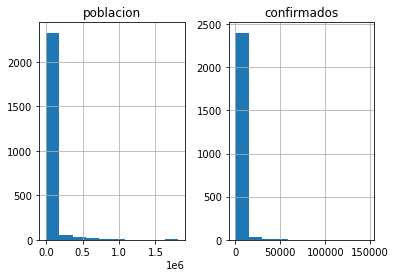

In [112]:
datos[['poblacion', 'confirmados']].hist()
plt.show()

##Correlación

Se encuentra la correlación entre la variable independiente población con la variable dependiente confirmados

In [113]:
corr_test = pearsonr(x = datos['poblacion'], y = datos['confirmados'])
print('Coefiente de correlación de Pearson:', corr_test[0])
print('P-value:', corr_test[1])

Coefiente de correlación de Pearson: 0.7955600277967804
P-value: 0.0


Fórmula de correlación de Pearson:

$$
\displaystyle \text{Coef. de correlación de Pearson} (r) = \frac{cov(x,y)} {s_xs_y} =\frac{\sum(x_i-\bar{x})(yi-\bar{y})} {(N-1)s_xs_y}\\
$$

De acuerdo a la tabla de correlación de Pearson se emplean como medida de la fuerza de asociación entre dos variables (tamaño del efecto):

*  0.0: asociación nula
*  0.1: asociación pequeña
*  0.3: asociación mediana
*  0.5: asociación moderada
*  **0.7: asociación alta**
*  0.9: asociación muy alta

Haciendo uso de la correlación de Pearson podemos observar el nivel de relación que existe entre la variable independiente 'poblacion' y la variable dependiente 'confirmados'; da como resultado *0.7955* y checando la lista de arriba podemos ver como es una asociación alta lo cual representa una gran relación entre la población y los confirmados, esto representa que entre más población tenga un municipio, más contagiados pueden confirmarse.

## Diagrama de dispersión

Text(0, 0.5, 'CONFIRMADOS')

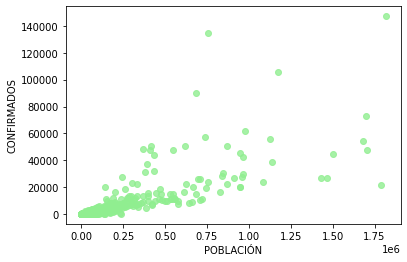

In [114]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.scatter(x = datos['poblacion'], y = datos['confirmados'], alpha = 0.8, c = 'lightgreen')
ax.set_xlabel('POBLACIÓN')
ax.set_ylabel('CONFIRMADOS')

##Validación cruzada

La validación cruzada consiste en dividir el conjunto de datos en dos partes:

*  Datos de entrenamiento para crear el modelo y evaluar la eficiencia del mismo.
*  Datos de validación para probar el modelo haciendo predicciones.

Se utilizarán las siguientes variables:

*  x_entrena_poblacion: son los valores de población para entrenar el modelo.
*  x_valida_población: son los valores de población para probar el modelo
*  y_entrena_poblacion: son los valores de confirmados para entrenar el modelo.
*  y_valida_confirma: son los valores de confirmados con los cuales se comparan las predicciones


## Partiendo los datos

In [115]:
poblacion = datos[['poblacion']]
confirmados = datos[['confirmados']]

In [116]:
entrena_poblacion, valida_poblacion, entrena_confirma, valida_confirma = train_test_split(
    poblacion.values.reshape(-1, 1),
    confirmados.values.reshape(-1, 1),
    train_size = 0.8,
    random_state = 2021,
    shuffle = True    
)

Los datos de entrenamiento representan el 80% del total de los datos y el 20% es para realizar validaciones.

El modelo se construye con los datos de entrenamiento, en este caso con las variables identificadas con entrena_poblacion y entrena_confirma

##Construyendo el modelo
Se construye el modelo de regresión lineal

In [117]:
modelo = LinearRegression()
modelo.fit(X = entrena_poblacion.reshape(-1, 1), y = entrena_confirma)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#Evaluando el modelo

In [118]:
print('Coeficiente de la intercepción:', modelo.intercept_)
print('Coeficiente de la pendiente:', modelo.coef_)
print('Coeficiente de determinación de R^2 o R Square:', modelo.score(X = entrena_poblacion, y = entrena_confirma))


Coeficiente de la intercepción: [-431.17383614]
Coeficiente de la pendiente: [[0.03636402]]
Coeficiente de determinación de R^2 o R Square: 0.6170721867551827


El valor del coeficiente de determincación es 0.6170 en regresión lineal simple significa que la representatividad que tiene la población con respecto a los casos confirmados o lo que es lo mismo, el valor de la población representa un 61.70% del valor de los casos confirmados.

R2 describe la proporción de varianza de la variable respuesta explicada por el modelo y relativa a la varianza total.

R2 explica la variabilidad de los datos de la variable de respuesta o la variable independiente población explica un 62% la variable confirmados.

Con esto podemos saber que la población afecta en un 62% la transmisión del virus lo cual indica que la cantidad de habitantes que tiene cada municipio no influye de forma total en la tasa de confirmados, por mencionar algunos posibles factores: las actividades económicas de la región, la cantidad de turistas que visitan el lugar y el flujo diario de personas que transitan por la ciudad.

#Predicciones
Reaizar 5 predicciones con los datos de validación

Se tiene un 61% de certeza que de las predicciones de casos confirmados se acercarán a las reales

In [128]:
prediccion = modelo.predict([[31803]])
print(int(prediccion))
i = 0

for x in valida_poblacion:
   if i > 5:
     break
   prediccion = modelo.predict([x])
   if(prediccion > 0):
     print('Población: ', x, 'Predicción:', int(prediccion))
   else:
     print('Población: ', x, 'Predicción:', int(0))
   i+=1

725
Población:  [16053] Predicción: 152
Población:  [11168] Predicción: 0
Población:  [37479] Predicción: 931
Población:  [5578] Predicción: 0
Población:  [21836] Predicción: 362
Población:  [1140] Predicción: 0


#Interpretación

El caso me dejo a entender que al darle un mejor tratamiento a los datos es más facil poder probarlos y confirmarlo, con los datos de validación, poder separar el conjunto de datos en un conjunto de entrenamiento y en un conjunto de validación permite que se puedan hacer predicción una vez que el modelo haya "aprendido" a como detectar las tendencias entre los contagios y la población de los municipios.

Entre más certero sea el modelo se tiene más seguridad al realizar las predicciones ya que los resultados serán más cercanos a los reales y servirá para poder implantar posible acciones para prevenir más contagios.

Para la predicción de los 5 casos:
*  Población:  [16053] Predicción: 152
*  Población:  [11168] Predicción: 0
*  Población:  [37479] Predicción: 931
*  Población:  [5578] Predicción: 0
*  Población:  [21836] Predicción: 362
*  Población:  [1140] Predicción: 0

Según las predicciones, en los municipios que tienen más de 12,000 habitantes es más posible la confirmacion de casos de COVID pero aun con esto se tiene un 62% de certeza de que sea asi en realidad, solo termina siendo una estimación de lo que podría suceder según la cantidad de habitantes pero aun la población solo es otro factor en los contagios por ejemplo: las actividades económicas de la región, la cantidad de turistas que visitan el lugar y el flujo diario de personas que transitan por la ciudad; son otros factores que se pueden tener en cuenta al hacer un analisis de casos confirmados de COVID.